In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl


import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

# Confirming your allensdk version
print(f"Your allensdk version is: {allensdk.__version__}")

In [ ]:
# Update this to a valid directory in your filesystem. This is where the data will be stored.
output_dir = "./AllenData"
DOWNLOAD_COMPLETE_DATASET = False

In [ ]:
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

In [ ]:
ecephys_sessions_table = cache.get_ecephys_session_table()
ecephys_sessions_table = ecephys_sessions_table[ecephys_sessions_table['experience_level']=='Familiar']   # Familiar with images
mouse_id = ecephys_sessions_table['mouse_id'].values
mice     = []

for id in range(len(np.unique(mouse_id))):
    mice.append(ecephys_sessions_table.index[np.where(mouse_id==np.unique(mouse_id)[id])[0]][0])

session       = mice[9]
Session       = cache.get_ecephys_session(ecephys_session_id=session)
units         = Session.get_units()
channels      = Session.get_channels()
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True).sort_values('probe_vertical_position', ascending=False)

good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))
good_units       = unit_channels.loc[good_unit_filter] 


all_spike_times        = Session.spike_times
stimulus_presentations = Session.stimulus_presentations
stim_table             = stimulus_presentations[(stimulus_presentations['stimulus_block']==0) & (stimulus_presentations['image_name']=='im036_r')]  # active block

num_cells = len(all_spike_times)
stims     = stim_table['start_time'].values
durs      = stim_table['duration'].values





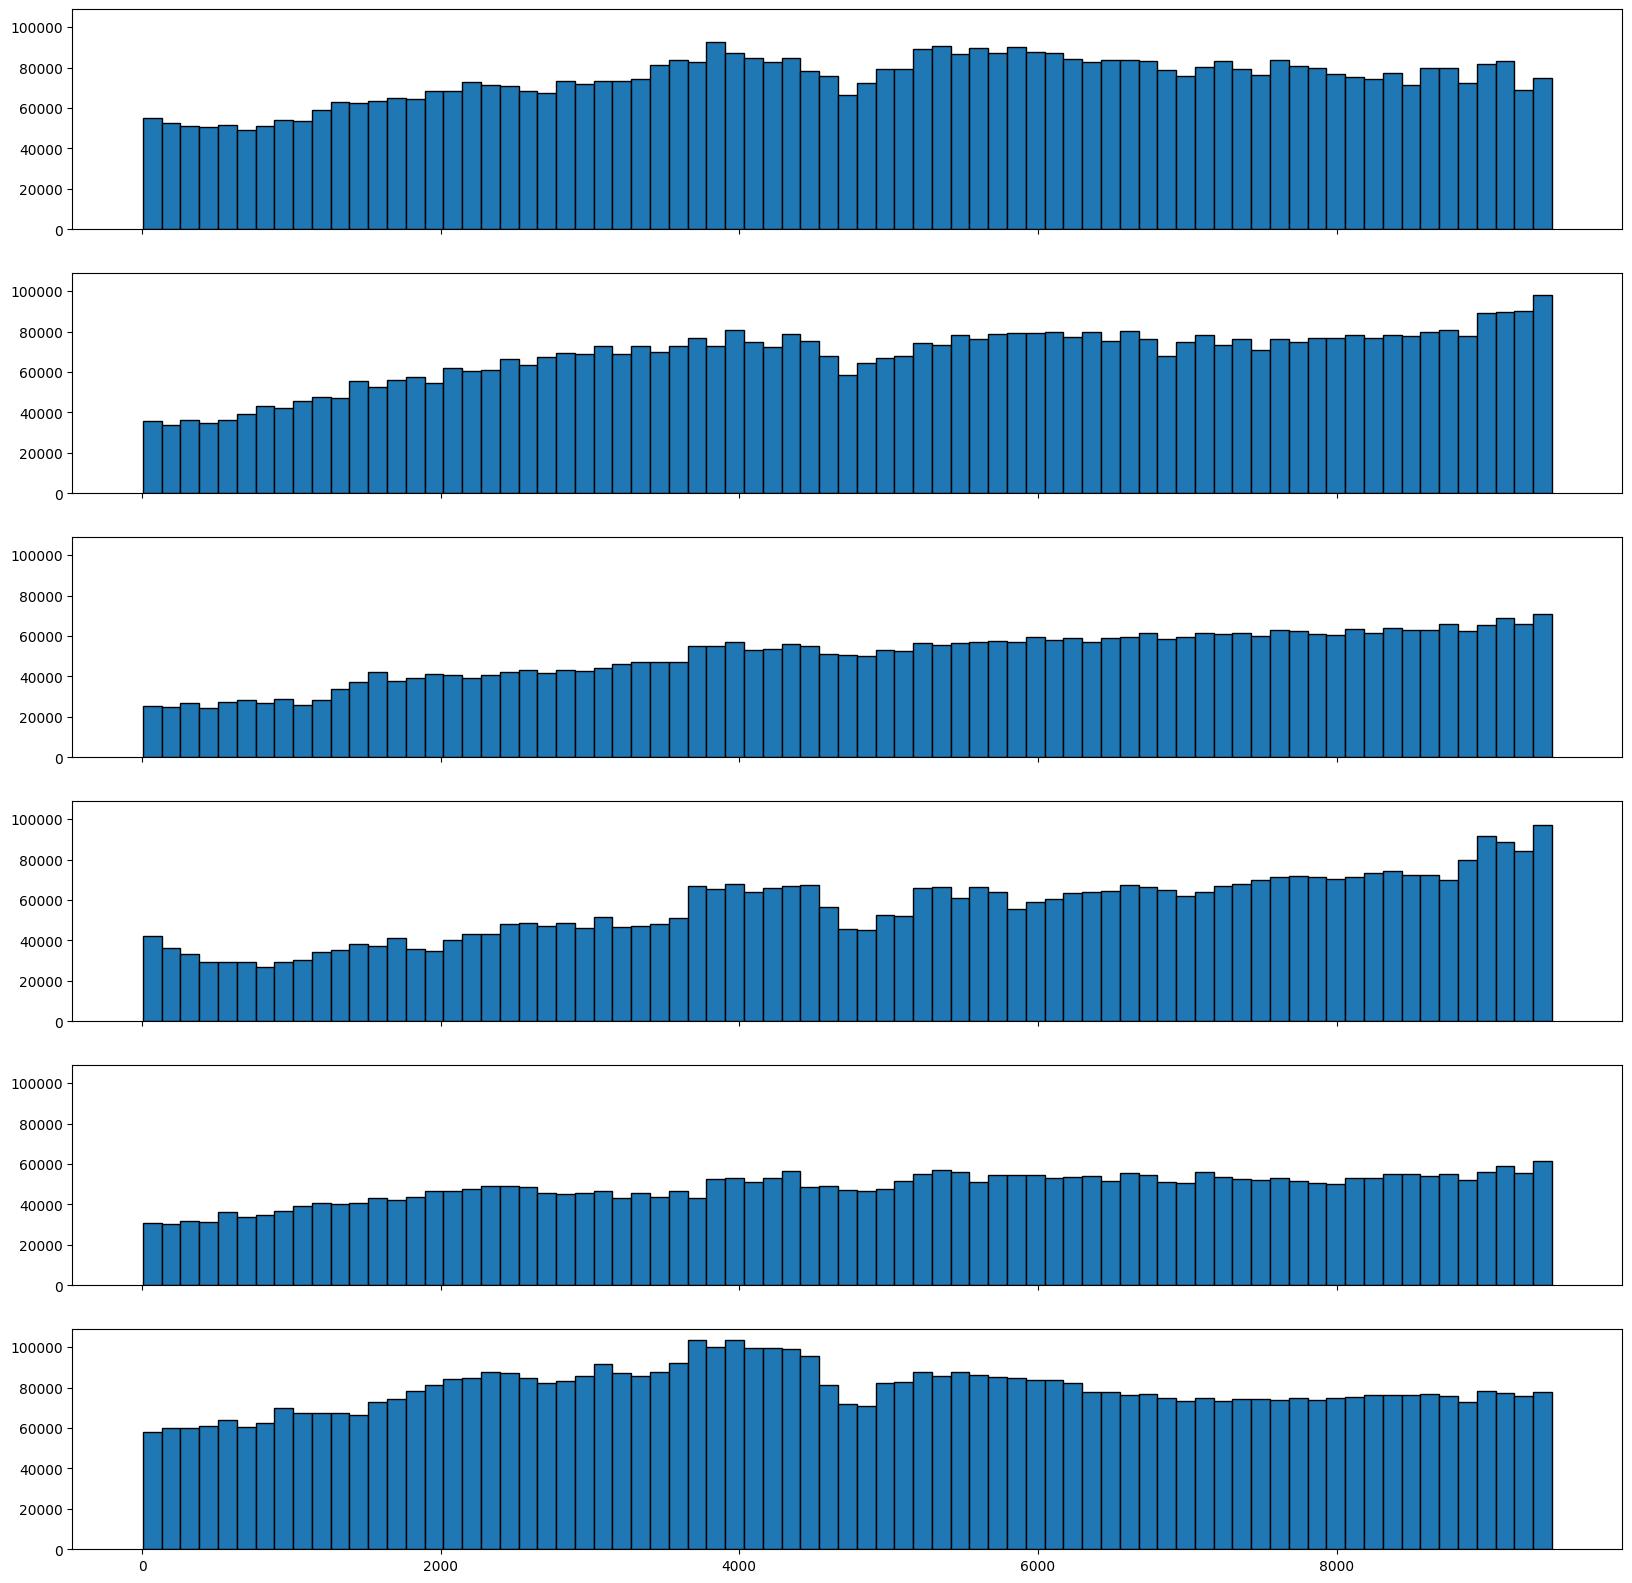

In [148]:

brainRegions = []
for j in good_units['structure_acronym']:
    if j in brainRegions:
        x = 0
    else:
        brainRegions.append(j)

#Load the good units for each visual region
good_units_VISal     = good_units[good_units['structure_acronym']=='VISal']
good_units_VISp      = good_units[good_units['structure_acronym']=='VISp']
good_units_VISam    = good_units[good_units['structure_acronym']=='VISam']
good_units_VISpm     = good_units[good_units['structure_acronym']=='VISpm']
good_units_VISrl     = good_units[good_units['structure_acronym']=='VISrl']
good_units_VISl     = good_units[good_units['structure_acronym']=='VISl']



ids_VISal = np.array(good_units_VISal['cluster_id'].keys())
ids_VISp = np.array(good_units_VISp['cluster_id'].keys())
ids_VISam = np.array(good_units_VISam['cluster_id'].keys())
ids_VISpm = np.array(good_units_VISpm['cluster_id'].keys())
ids_VISrl = np.array(good_units_VISrl['cluster_id'].keys())
ids_VISl = np.array(good_units_VISl['cluster_id'].keys())

first = True
for i in range(len(ids_VISal)):
    if first:
        testTrainVISal = np.array(all_spike_times[ids_VISal[i]])
        first = False
    else:
        testTrainVISal = np.append(testTrainVISal, np.array(all_spike_times[ids_VISal[i]]))
       
def makeTrain(ids, allSpikes):
    first = True
    for i in range(len(ids)):
        if first:
            testTrain = np.array(allSpikes[ids[i]])
            first = False
        else:
            testTrain = np.append(testTrain, np.array(allSpikes[ids[i]]))
    return testTrain


VISalTrain = makeTrain(ids_VISal, all_spike_times)
VISpTrain = makeTrain(ids_VISp, all_spike_times)
VISamTrain = makeTrain(ids_VISam, all_spike_times)
VISpmTrain = makeTrain(ids_VISpm, all_spike_times)
VISrlTrain = makeTrain(ids_VISrl, all_spike_times)
VISlTrain = makeTrain(ids_VISl, all_spike_times)




fig, ax = plt.subplots(6,1, sharex = True,sharey=True, figsize = (20,20))

binNum = 75


countsVISal, binsVISal = np.histogram(VISalTrain, bins=binNum)
countsVISp, binsVISp = np.histogram(VISpTrain, bins=binNum)
countsVISam, binsVISam = np.histogram(VISamTrain, bins=binNum)
countsVISpm, binsVISpm = np.histogram(VISpmTrain, bins=binNum)
countsVISrl, binsVISrl = np.histogram(VISrlTrain, bins=binNum)
countsVISl, binsVISl = np.histogram(VISlTrain, bins=binNum)

ax[0].bar(binsVISal[:-1],countsVISal,width=np.diff(binsVISal), align='edge', edgecolor='black')
ax[1].bar(binsVISp[:-1],countsVISp,width=np.diff(binsVISp), align='edge', edgecolor='black')
ax[2].bar(binsVISam[:-1],countsVISam,width=np.diff(binsVISam), align='edge', edgecolor='black')
ax[3].bar(binsVISpm[:-1],countsVISpm,width=np.diff(binsVISpm), align='edge', edgecolor='black')
ax[4].bar(binsVISrl[:-1],countsVISrl,width=np.diff(binsVISrl), align='edge', edgecolor='black')
ax[5].bar(binsVISl[:-1],countsVISl,width=np.diff(binsVISl), align='edge', edgecolor='black')



plt.show()


24182 103644


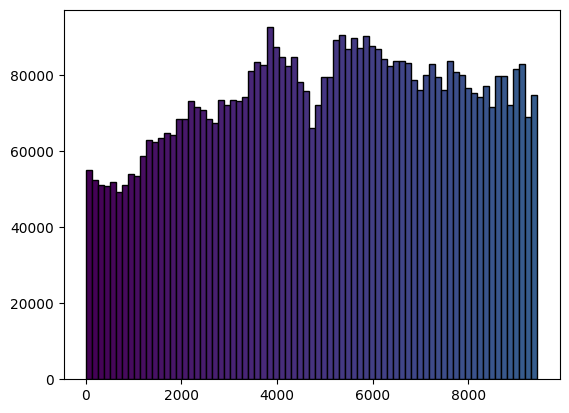

In [167]:
countList = [countsVISal,countsVISp,countsVISam,countsVISpm,countsVISrl,countsVISl]

maxCount = 0
minCount = 1000000000
for i in countList:
    maxHere = max(i)
    if maxHere>maxCount:
        maxCount = maxHere

    minHere = min(i)
    if minHere < minCount:
        minCount = minHere
        
print(minCount,maxCount)

viridis = mpl.colormaps['viridis'].resampled(8)

plt.bar(binsVISal[:-1],countsVISal,width=np.diff(binsVISal), align='edge', edgecolor='black',color = colors )



plt.show()
